<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/neutrons-background-1/tutorials/Eljen-Background-Characterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/neutrons-background-1/tutorials/Eljen-Background-Characterization.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Eljen Detector Background Characterization

### Prequel - What's an Eljen detector ?

Eljen scintillator detectors work by converting ionizing radiation into visible light. Radiation excites molecules in the plastic; these de-excite and emit photons. The light is detected by a photomultiplier tube (PMT) or Silicon photomultiplier (SiPM), producing an electrical signal proportional to the energy deposited.

## 5 and 2 inch Eljen detector - December 2024/ January 2025

Our goal is to characterize the background radiation as picked up by the 2" and 5" Eljen detectors. In order to do so, we ran the Eljen detectors in question throughout December 2024 and January 2025. We will now characterize this background---which will be useful for future analysis.

In this notebook, we start by diving into the data from the 2inch liquid scintillation detector.

In [1]:
# RUN THIS IF YOU ARE USING GOOGLE COLAB
import sys
import os
!git clone https://github.com/project-ida/arpa-e-experiments.git
sys.path.insert(0,'/content/arpa-e-experiments')
os.chdir('/content/arpa-e-experiments')

Cloning into 'arpa-e-experiments'...
remote: Enumerating objects: 415, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 415 (delta 91), reused 76 (delta 43), pack-reused 265 (from 1)
Receiving objects: 100% (415/415), 32.45 MiB | 4.61 MiB/s, done.
Resolving deltas: 100% (225/225), done.
Updating files: 100% (55/55), done.


In [2]:
# Libraries and helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import ipywidgets as widgets
from IPython.display import display

from IPython.display import Image
from IPython.display import Video
from IPython.display import HTML

# Use our custom helper functions
# - process_data
# - plot_panels
# - plot_panels_with_scatter
# - print_info
from libs.helpers import *

In [3]:
meta = {
    "descriptor" : "Eljen 2 inch 12-2024" # This will go into the title of all plots
}

## Step 1 - Data Collection

Let's begin by collecting raw data on the Eljen detectors of interest, ie the 2 inch detector to begin.  

We have collected long-term data on the neutron and gamma counts per sond picked up by our Eljen detectors, from December 14th 2024 00:01:01 to January 23rd, 2025 23:58:59. They are defined as dataframes, which we can manipulate using pandas, below.

In [4]:
neutron_df = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/eljen-2inch-long-term-1.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

gamma_df = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/eljen-2inch-long-term-4.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

In [6]:
# we will also startnumbering our figures here for easier reference later in the notebook'
fig_counter = 0

## Step 2 - Visualizing Neutron and Gamma counts

Now that we have collected the raw data (i.e. electric signal history) that interests us, let us have a look at the measured neutron and gamma counts.

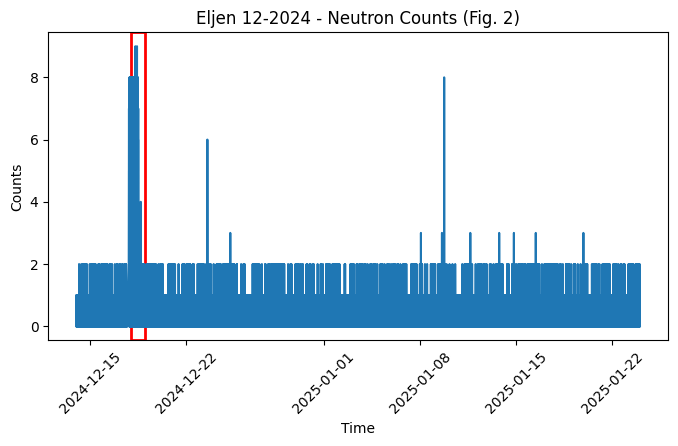

In [8]:
from matplotlib.patches import Rectangle
fig_counter += 1

plt.figure(figsize=(8, 4))
plt.plot(neutron_df['Counts'])
plt.xlabel('Time')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} - Neutron Counts (Fig. {fig_counter})")

# highlight December 18th because this corresponds to a neutron burst due to the introduction of Cf-252
ax = plt.gca()
start = pd.to_datetime('2024-12-18')
end   = start + pd.Timedelta(days=1)
ymin, ymax = ax.get_ylim()
rect = Rectangle((start, ymin), end-start, ymax-ymin,
                 linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

plt.show()
# plt.savefig("all-neutron-counts-sec.png", dpi=600)

We notice in the above plot a sharp neutron burst on 18 December (highlighted by the red square in Fig. 1). This spike coincides exactly with the introduction of a ²⁵²Cf source into the laboratory.

According to the LNHB decay tables, ²⁵²Cf disintegrates by α-emission almost exclusively to the ground state of ²⁴⁸Cm, and undergoes spontaneous fission with a branching ratio of $3.086 (8)%$ ([LNHB Cf-252 tables](http://www.lnhb.fr/nuclides/Cf-252_tables.pdf)). In each fission event, an average of $3.7675 (40)$ neutrons are emitted, yielding:

$$
n \;=\; 3.086\% \times 3.7675 \;\approx\; 0.11627\ \text{neutrons per decay}
\quad\longrightarrow\quad
11.627\ \text{neutrons per 100 decays}
$$

Furthermore, spontaneous fission of ²⁵²Cf is accompanied by prompt γ-rays emitted within $10^{-14}$–$10^{-12}\,\text{s}$ of fragment formation (cf https://www.sciencedirect.com/science/article/pii/0375947475904820?utm). The average γ-multiplicity is approximately 10.3 photons per fission (cf https://link.springer.com/article/10.1007/BF02847802?utm), essentially simultaneous with neutron emission. Therefore, we expect to observe a coincident γ-burst in any detector with sufficient energy threshold and timing resolution, aligned with the neutron spike seen on 18 December.

This is indeed the case in the following plot.

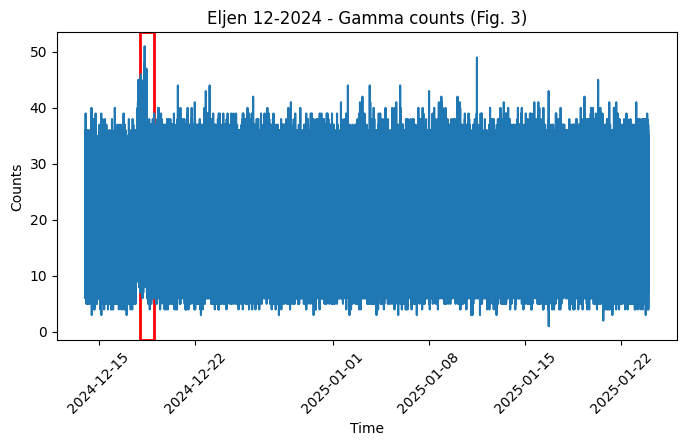

In [9]:
fig_counter +=1

plt.figure(figsize=(8, 4))
plt.plot(gamma_df['Counts'])
plt.xlabel('Time')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} - Gamma counts (Fig. {fig_counter})")

# highlight December 18th with a red square
ax = plt.gca()
start = pd.to_datetime('2024-12-18')      # adjust year if needed
end   = start + pd.Timedelta(days=1)
ymin, ymax = ax.get_ylim()
rect = Rectangle(
    (start, ymin),
    end - start,
    ymax - ymin,
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect)


plt.show()
# plt.savefig("all-gamma-counts-sec.png", dpi=600)

## Step 3 - Resampling data and Removing Neutron burst

The current data is taken about once per second. We'll now aggregate this data to present counts in 1 minute intervals.

Furthermore, we noticed above a neutron and gamma burst on December 18th. This corresponded to a time-period in which we brought a Cf-252 neutron source into the lab (ie the bursts that the detectors are picking up). Hence, in order to define a clear background time, we will start collecting data from December 19th.

So, in sum, the next step is to :


1. **Aggregate** the raw second-by-second counts into 1 minute bins.  
2. **Exclude** the burst period when the ²⁵²Cf source was in the lab (i.e. December 18), and begin our background analysis on December 19.

In [13]:
neutron_df_1_minute = neutron_df.resample('1min').sum()
gamma_df_1_minute = gamma_df.resample('1min').sum()

# Assuming neutron_df_1_minute has a datetime index
start_time = "2024-12-19 00:00:00"
end_time = "2025-01-23 23:59:00"

neutron_df_1_minute_background = neutron_df_1_minute.loc[start_time:end_time]
gamma_df_1_minute_background = gamma_df_1_minute[start_time:end_time]

## Step 4 - Analyzing the Bakground Counts

Now that we have excluded the time before and when the neutron source was introduced, let us have a closer look at our background neutron counts.

We will start by building a daily histogram of the background neutron counts per minute. Each line in the plot will represent one day’s worth of 1 minute bins, normalized to form a probability distribution. This lets us see how the shape of the count distribution varies from day to day.

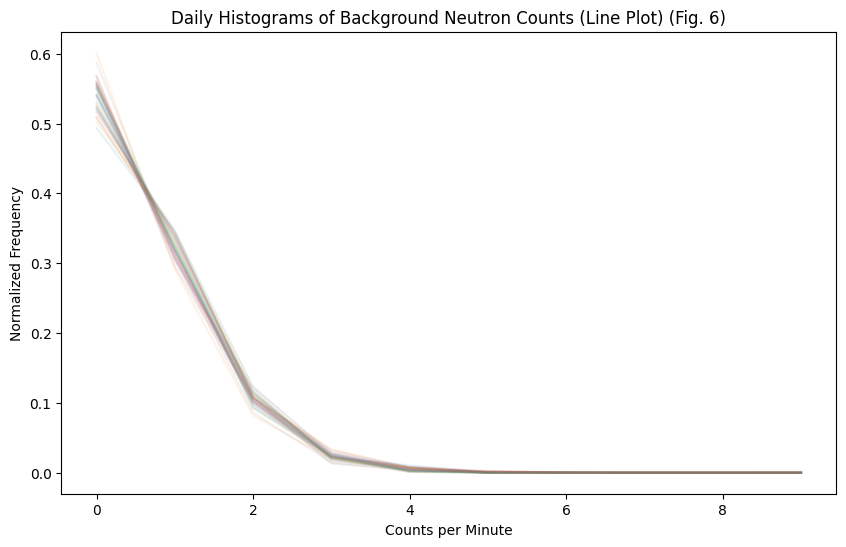

In [14]:
fig_counter +=1

# Ensure the index is datetime
neutron_df_1_minute_background.index = pd.to_datetime(neutron_df_1_minute_background.index)

# Group by day
grouped_by_day = neutron_df_1_minute_background.groupby(neutron_df_1_minute_background.index.date)

# Define bins for the histogram
bins = np.arange(neutron_df_1_minute_background["Counts"].min(),
                 neutron_df_1_minute_background["Counts"].max() + 1, 1)  # Use integer bins

# Plot all histograms as line plots
plt.figure(figsize=(10, 6))

for day, group in grouped_by_day:
    hist_values, bin_edges = np.histogram(group["Counts"], bins=bins, density=True)
    plt.plot(bin_edges[:-1], hist_values, alpha=0.1, label=str(day))

plt.xlabel("Counts per Minute")
plt.ylabel("Normalized Frequency")
plt.title(f"Daily Histograms of Background Neutron Counts (Line Plot) (Fig. {fig_counter})")
plt.show()

Quick comment on how to read this plot:

- Each line corresponds to one calendar day’s distribution of 1 minute neutron counts.
- Horizontal axis: number of counts detected in a 1 min bin.
- Vertical axis: normalized frequency (so that areas under each curve sum to 1).
- The shading/transparency helps you see where multiple days’ distributions overlap. Each color corresponds to the data from a different day.

In order to conduct a statistical analysis on these background counts, we need to have an idea of what qualifies as a "significant" deviation from background. This will be of interest when trying to determine whether or not we have detected an abnormal number of neutron counts.

## Side-step 4.1 Expected Poisson Distribution

Neutron background counts are typically modeled by a Poisson distribution because they arise from random, independent events which occur at a constant average rate over time. This aligns with the conditions under which the Poisson distribution is valid:

- Rare Events: Background neutrons are detected infrequently and individually—each detection is a discrete event.

- Statistical Independence: The arrival of one neutron does not affect the probability of another arriving.

- Constant Rate: Over short timescales (like 1-minute bins), the average background rate is approximately constant.

- Fixed Observation Interval: Counts are measured over uniform time intervals (ie counted over fixed 1 minute intervals).

Under these conditions, the number of neutrons detected in a fixed time interval follows a Poisson distribution with mean λ, where λ is the expected number of events (neutrons) per interval.

The standard deviation is thus $\sigma = \sqrt{λ}$

We will consider that count is "significantly high" if it exceeds $\lambda + \sqrt{\lambda}\cdot Z$

where $Z = 3$ corresponds to a $3\sigma$ threshold (confidence level ~99.7%)

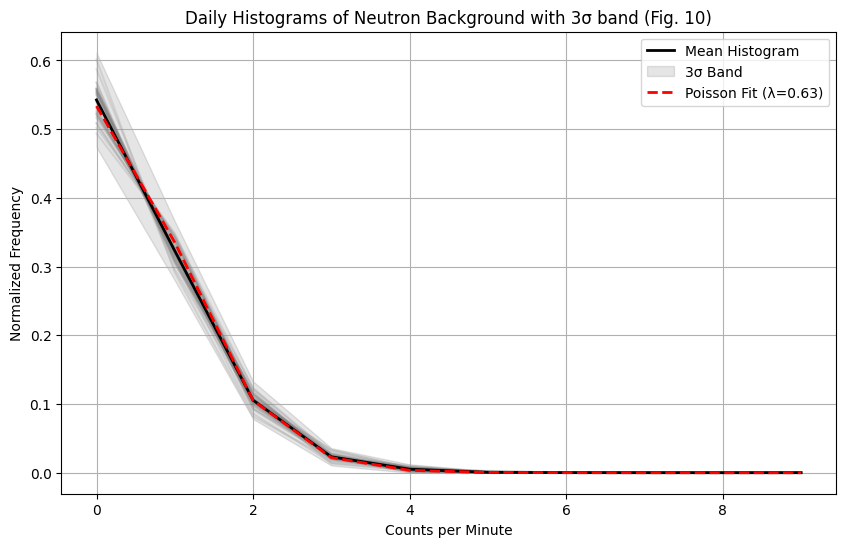

In [34]:
fig_counter += 1

histograms = []
for day, group in grouped_by_day:
    hist_values, bin_edges = np.histogram(group["Counts"], bins=bins, density=True)
    histograms.append(hist_values)

# Convert list to array and compute mean + std across days
histograms = np.array(histograms)
mean_histogram = np.mean(histograms, axis=0)
std_histogram = np.std(histograms, axis=0)

# Estimate Poisson background mean
lambda_ = neutron_df_1_minute_background["Counts"].mean()
threshold_3sigma = lambda_ + 3 * np.sqrt(lambda_)


# Poisson fit
k_values = bin_edges[:-1]  # Use bin centers (left edges)
poisson_pmf = stats.poisson.pmf(k_values, mu=lambda_)

# Normalize Poisson PMF for visual comparison
poisson_pmf_normalized = poisson_pmf / np.sum(poisson_pmf)  # Normalize manually
poisson_pmf_normalized *= np.sum(mean_histogram)  # Match total area to empirical hist

plt.figure(figsize=(10, 6))

# daily histograms
for hist_values in histograms:
    plt.plot(bin_edges[:-1], hist_values, alpha=0.2, color='gray')

# mean histogram
plt.plot(bin_edges[:-1], mean_histogram, color='black', linewidth=2, label='Mean Histogram')

# 3σ band
plt.fill_between(bin_edges[:-1],
                 np.maximum(mean_histogram - 3 * std_histogram, 0),
                 mean_histogram + 3 * std_histogram,
                 color='black', alpha=0.1, label='3σ Band')

# Poisson fit overlay
plt.plot(k_values, poisson_pmf_normalized, 'r--', linewidth=2, label=f'Poisson Fit (λ={lambda_:.2f})')

plt.xlabel("Counts per Minute")
plt.ylabel("Normalized Frequency")
plt.title(f"Daily Histograms of Neutron Background with 3σ band (Fig. {fig_counter})")
plt.legend()
plt.grid(True)
plt.show()


Let's take a step back to understand what we are looking at here.

The black line corresponds to the average distribution of neutron counts across all days.

The grey shaded area shows the spread of day-to-day variation, with upper and lower bounds at 3 standard deviations above and below the mean. Days that would lie outside this band would be statistically rare under normal conditions (probability < 0.3%). Hence, we may identify neutron bursts in future runs by looking at "outliers" of this grey shaded area.

The red dashed line corresponds to the theoretical distribution assuming that neutron counts follow a Poisson process. We plotted this normalized Poisson ditribution assuming the Poisson paramter $\lambda$ to me the mean of our background data i.e. $\lambda \approx 0.63$.

### Quantitative goodness-of-fit

In order to test more rigorously whether our background truly follows a Poisson process, we can perform a $χ^2$ (chi-square) goodness-of-fit test comparing the observed mean histogram to the expected Poisson probabilities:

1. Compute the test statistic  
   $$
     \chi^2 = \sum_{k} \frac{(O_k - E_k)^2}{E_k},
   $$
   where $O_k$ are the observed counts in bin $k$ (from the mean histogram) and $E_k = N_{\rm tot}\,P_{\rm Poisson}(k;\lambda)$.  
2. Under the null hypothesis (data ∼ Poisson\($\lambda)$, $\chi^2$ follows a $\chi^2$ distribution with $\text{Degrees of Freedom} = \text{number of bins} - 1 - 1$ (subtracting one for the estimated $\lambda$ and 1 for normalization).  
3. A large $p$-value $(p>0.05$) implies we cannot reject the Poisson hypothesis at the $5 \%$ level.

In the code below, we conduct this goodness of fit analysis and find a p value of $p = 0.9996229005$ so we cannot reject the null-hypothesis. Hence, for our purposes, we are in a good position to say that background follows a Poisson process.

In [36]:
# — Chi-square goodness-of-fit test —
# Aggregate observed counts across all days
O_counts = histograms.sum(axis=0)       # observed total counts per bin
N_tot = O_counts.sum()                         # total number of 1-min intervals

# Expected counts under Poisson(λ)
pk = stats.poisson.pmf(k_values, mu=lambda_)
E_counts = N_tot * pk

# Compute χ² statistic and p-value
chi2_stat = np.sum((O_counts - E_counts)**2 / E_counts)
dof = len(k_values) - 2  # degrees of freedon = bins minus 1 (normalization) minus 1 (λ estimated)
p_value = stats.chi2.sf(chi2_stat, dof)

print(f"Chi-square statistic: {chi2_stat:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value:.10f}")

if p_value > 0.05:
    print("Cannot reject Poisson(λ) at the 5% significance level.")
else:
    print("Data significantly deviate from Poisson(λ).")


Chi-square statistic: 0.66
Degrees of freedom: 8
p-value: 0.9996229005
Cannot reject Poisson(λ) at the 5% significance level.


## Side-Step 4.2 – Stability of the Background Rate and Normality of Daily Means

Furthremore, before trusting the aformentioned single global $\lambda$, we should check how much the daily average neutron count per minute varies over our measurement period—and whether those daily means themselves follow an approximately normal distribution (by the Central Limit Theorem, if $\lambda$ is truly constant).


Daily mean counts per minute: μ = 0.63, σ = 0.04


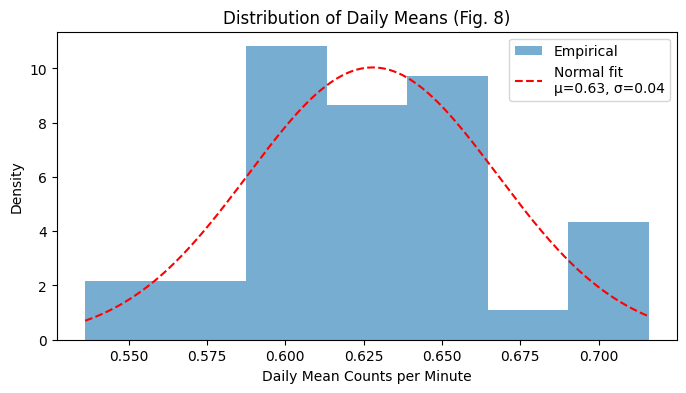

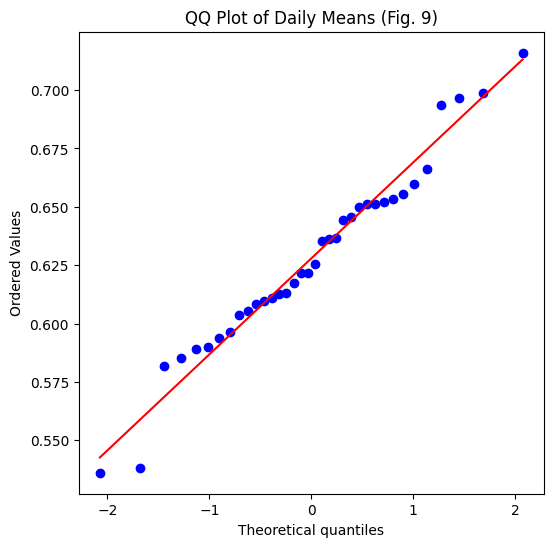

In [19]:
# 1. Compute daily means
daily_means = [group["Counts"].mean() for _, group in grouped_by_day]
days = list(grouped_by_day.groups.keys())

# 2. Summary statistics
mu_daily   = np.mean(daily_means)
sigma_daily = np.std(daily_means)
print(f"Daily mean counts per minute: μ = {mu_daily:.2f}, σ = {sigma_daily:.2f}")

# 3. Histogram of daily means with Normal fit overlay
plt.figure(figsize=(8, 4))
# histogram
vals, edges, _ = plt.hist(daily_means, bins='auto', density=True, alpha=0.6, label='Empirical')
# normal PDF
x = np.linspace(min(edges), max(edges), 200)
pdf = stats.norm.pdf(x, loc=mu_daily, scale=sigma_daily)
plt.plot(x, pdf, 'r--', label=f'Normal fit\nμ={mu_daily:.2f}, σ={sigma_daily:.2f}')
plt.xlabel('Daily Mean Counts per Minute')
plt.ylabel('Density')
plt.title(f'Distribution of Daily Means (Fig. {fig_counter+1})')
plt.legend()
plt.show()

# 4. QQ-plot for normality check
plt.figure(figsize=(6, 6))
stats.probplot(daily_means, dist="norm", plot=plt)
plt.title(f'QQ Plot of Daily Means (Fig. {fig_counter+2})')
plt.show()

The above plots show that the daily mens are tightly clustered, which supports our above assumption of a stable background rate.

So, it is a reasonable assumption to claim that our $\lambda$ is essentially constant over the January-December background collection period.

## Step 5 – From Statistical Characterization to an Actionable Protocol

### 1. Summary of Background Characterization  

Let's take a quick break to see what we have established so far:

**Poisson behavior confirmed.**  
- Chi-square test on the aggregated daily histograms yielded $\chi^2 = 0.66$, $dof = 8$, $p = 0.9996229005$, so we cannot reject that our long-term background follows $\mathrm{Poisson}(\lambda)$.  

**Mean and variance stability.**  
  - Global background rate  
    $$
      \lambda = 0.63 \;\text{counts/min},
      \quad \sigma_{\rm bkg} = \sqrt{\lambda} \approx 0.79.
    $$  
  - Daily‐mean distribution was nearly Gaussian with  
    $$\mu_{\rm daily}=0.63, \sigma_{\rm daily}=0.04$$

Together, these results show that over weeks of data our detector background is  

- Well described by a Poisson process with mean $\lambda$
- Highly stable

### 2. Protocol for Pre-Experiment “Quick Check”  

Let's now take a step back to remember the motivation for this notebook: background characterization of our Eljen detector. One of the main desired outcomes is thus a protocol to establish background for a new run using the Eljen detectors. In order to do this, we will propose the following:

Before each new experimental run, we should perform a short background measurement (e.g. few hours to 24 hours ideally) and then:

1. Compute the short-run mean  
   $$\hat\lambda_{\rm short} = \frac{\text{total counts in check}}{\text{duration in minutes}}$$
2. Compare to long-term λ ?
3. Goodness‐of‐fit test (optional)
   - Build a quick histogram of the short-run counts and perform a χ² test against $\mathrm{Poisson}(\lambda)$.  
   - If $p > 0.05$, background is consistent; otherwise investigate.  
4. Decision  
   - If consistent: proceed with the planned experiment.  
   - If anomalous: pause and check for  
     - Instrument issues   
     - Environmental changes
     - Cosmic‐ray “weather” ?

By embedding this “quick‐check” step into every experimental workflow, we ensure that our background conditions match the long‐term characterization before any experiment is conducted.

## Step 6 - Zooming in on outliers

Once we have established the stability of background, we are interested in determining whether any specific neutron burst is "significantly high". To do this, we use the well-established normal approximation to the Poisson distribution.

Given a Poisson process with mean rate $ \lambda $, the standard deviation is $ \sqrt{\lambda} $. Under this approximation, an observed count is considered statistically significant at Z standard deviations if:

$$ \text{Count} > \lambda + Z \cdot \sqrt{\lambda}$$

This method is commonly used in radiation measurement and other count-based detection systems, as detailed in:

- G. F. Knoll, *Radiation Detection and Measurement*, 4th ed., Wiley, 2010.

In [43]:
# Function to update the plot based on Z
def plot_outliers(Z):
    threshold_poisson = lambda_ + Z * np.sqrt(lambda_)
    poisson_outliers = neutron_df_1_minute_background[neutron_df_1_minute_background["Counts"] > threshold_poisson]

    plt.figure(figsize=(14, 5))
    plt.plot(neutron_df_1_minute_background.index, neutron_df_1_minute_background["Counts"],
             label="Counts per Minute", color='blue', linewidth=1)

    plt.scatter(poisson_outliers.index, poisson_outliers["Counts"],
                color='red', label=f"Outliers (> {threshold_poisson:.2f} counts)", zorder=5)

    plt.axhline(threshold_poisson, color='gray', linestyle='--', linewidth=1.5,
                label=f"Z = {Z:.1f} Threshold")

    plt.title(f"Neutron Count Time Series with Z={Z:.1f} Outlier Threshold")
    plt.xlabel("Time")
    plt.ylabel("Counts per Minute")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return threshold_poisson

## Interpreting the Outlier Threshold Plot

In the plot generated by the code above: `plot_outliers(Z)`, you’ll see:

- **Blue line**: the time series of 1-minute neutron counts during our background period.  
- **Gray dashed horizontal line**: the chosen significance threshold  
  $$
    \lambda + Z\,\sqrt{\lambda},
  $$  
  where $\lambda$ is the long-term background mean and $Z$ is the number of standard deviations.  
- **Red dots**: the individual 1-minute bins whose counts exceed that threshold and are therefore flagged as “outliers.”

### How to Read the Plot

1. **Threshold level**  
   - If you set \(Z=3\), the gray line sits at \(\lambda + 3\sqrt{\lambda}\).  
   - Under a pure Poisson background, fewer than 0.13% of minutes should exceed this threshold by chance alone.  

2. **Sensitivity vs. false-alarm rate**  
   - **Lower \(Z\)** makes the threshold lower and flags more bins (higher sensitivity but more false positives).  
   - **Higher \(Z\)** raises the bar, flagging only the most extreme bursts (fewer false alarms but possibly missing smaller but real events).

3. **Temporal context**  
   - Look at clusters of red dots: repeated outliers close in time may indicate a sustained burst or a transient change in background conditions.  
   - Isolated red dots could be statistical fluctuations (especially if \(Z\) is low).

4. **Choosing \(Z\) for your experiment**  
   - For routine background checks, \(Z=3\) is a common industry standard (≈99.7% confidence).  
   - If you need very low false-alarm rates, consider \(Z=4\) or higher.  
   - You can interactively adjust \(Z\) below to see how the balance between sensitivity and specificity changes.


In order to visualize the effect of choosing different values of $Z$, feel free to interact with the code block below and play around with the variables!

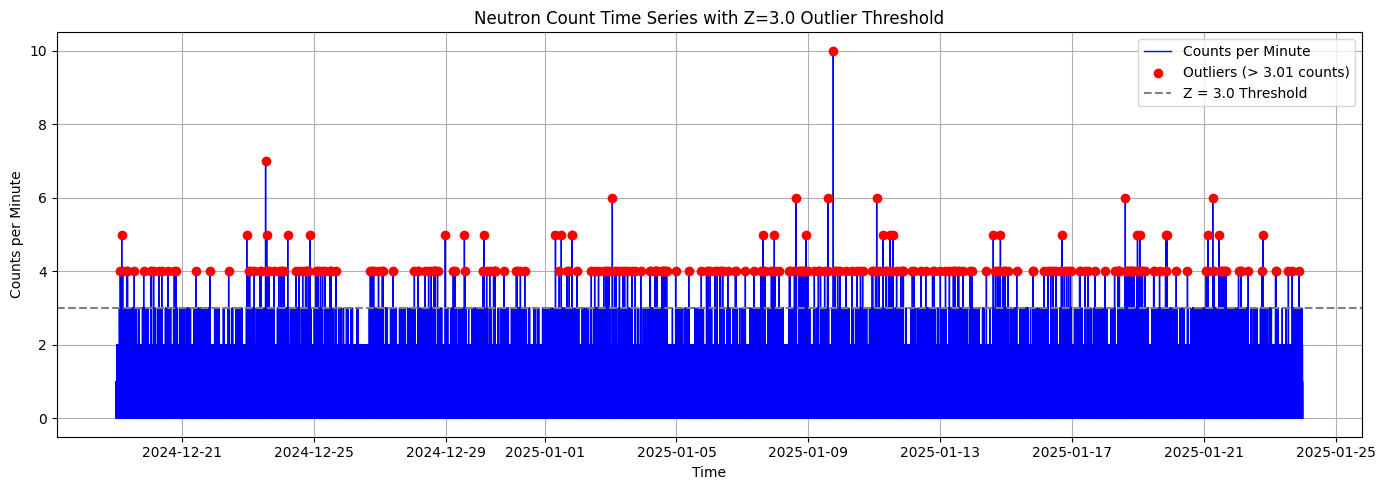

np.float64(3.005064723189387)

In [44]:
plot_outliers(Z=3)

## Accounting for Multiple Comparisons (Family-Wise Error Rate)

When you scan a long time series for outliers, each minute’s count is a separate hypothesis test (“is this minute an outlier?”).  If you keep using a fixed 3 σ threshold (per-test α≈0.00135), then over $N$ independent minutes your **family-wise error rate** (FWER) grows:

$$
\text{FWER} = 1 - (1 - \alpha)^N \approx N \cdot \alpha \quad (\text{for small }\alpha).
$$

For example, over a 1 day background run $(N≈1440$ minutes),  
$$
\text{FWER} \approx 1440 \times 0.00135 ≈ 1.94,
$$
i.e. almost certain to see at least one “false” 3 σ outlier just by chance.

Let's look into a possible solution for this issue: ?

### Bonferroni Correction

A simple (but conservative) fix is the **Bonferroni correction**, which sets the per-test α to  
$$
\alpha_{\rm per-test} = \frac{\alpha_{\rm family}}{N},
$$
so that  
$$
\text{FWER} \;\le\; N \times \alpha_{\rm per-test} = \alpha_{\rm family}.
$$  
If you want $\mathrm{FWER}=0.05$ over $N=1440$ minutes, then  
$$
\alpha_{\rm per-test} = \frac{0.05}{1440} \approx 3.5\times10^{-5},
$$
which corresponds to a threshold  
$$
Z_{\rm adj} = \Phi^{-1}(1 - \tfrac12\,\alpha_{\rm per-test}) \approx 4.0,
$$
i.e. roughly a 4 σ cut instead of 3 σ.


## New method for Visualizing Pointwise Poisson Probabilities

Rather than just flagging a binary outlier, we can compute for each 1-minute count $k$ its exact tail-probability under Poisson$(\lambda)$:

$$
p_k = P(\,K\ge k\,) \;=\; 1 - F(k-1;\lambda),
$$

and then plot $\log_{10}(p_k)$ against time.  This tells you at a glance how unlikely each point is, without choosing a hard $Z$.



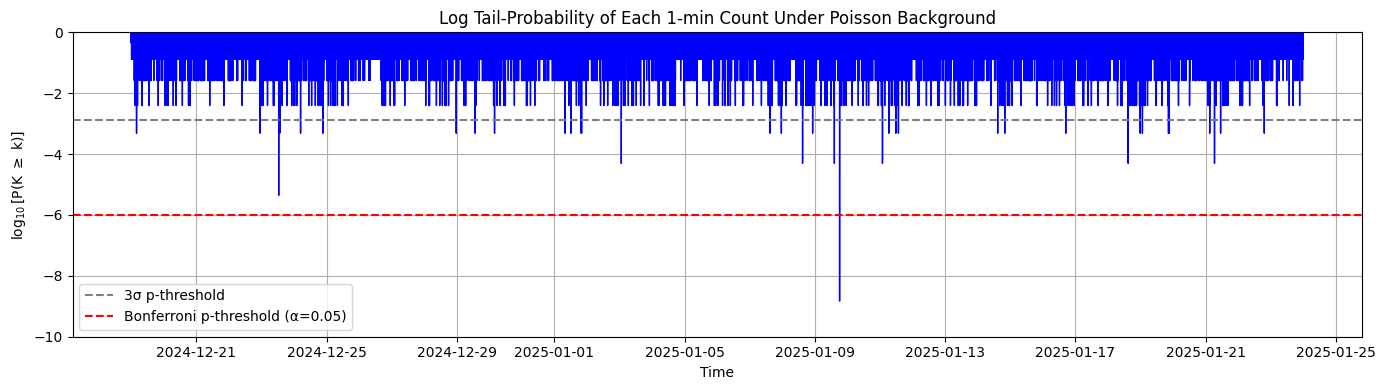

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# λ from long-term background
lambda_ = neutron_df_1_minute_background["Counts"].mean()

# Compute tail-probabilities and log10
counts = neutron_df_1_minute_background["Counts"].values.astype(int)
p_tail = 1 - poisson.cdf(counts - 1, mu=lambda_)
log_p = np.log10(p_tail)

# Plot log10(p-value) time series
plt.figure(figsize=(14, 4))
plt.plot(neutron_df_1_minute_background.index, log_p, lw=1, color='blue')
plt.axhline(np.log10(0.00135), color='gray', linestyle='--', label='3σ p-threshold')
plt.axhline(np.log10(0.05/len(counts)), color='red', linestyle='--',
            label='Bonferroni p-threshold (α=0.05)')
plt.ylim(-10, 0)
plt.xlabel("Time")
plt.ylabel(r"$\log_{10}$[P(K $\geq$ k)]")
plt.title("Log Tail-Probability of Each 1-min Count Under Poisson Background")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Let us now perform the same analysis for gamma counts.

In [ ]:
# Precompute Poisson mean for gamma background
lambda_gamma = gamma_df_1_minute_background["Counts"].mean()

# Define the plotting function
def plot_gamma_outliers(Z):
    threshold_poisson = lambda_gamma + Z * np.sqrt(lambda_gamma)
    poisson_outliers = gamma_df_1_minute_background[gamma_df_1_minute_background["Counts"] > threshold_poisson]

    plt.figure(figsize=(14, 5))
    plt.plot(gamma_df_1_minute_background.index, gamma_df_1_minute_background["Counts"],
             label="Gamma Counts per Minute", color='purple', linewidth=1)

    plt.scatter(poisson_outliers.index, poisson_outliers["Counts"],
                color='orange', label=f"{len(poisson_outliers)} Outliers (> {threshold_poisson:.2f} counts)", zorder=5)

    plt.axhline(threshold_poisson, color='gray', linestyle='--', linewidth=1.5,
                label=f"Z = {Z} Threshold")

    plt.title(f"Gamma Count Time Series with Z={Z} Outlier Threshold")
    plt.xlabel("Time")
    plt.ylabel("Gamma Counts per Minute")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Similarly to above, feel free to play around with $Z$ to observe the effect of its value on our count threshold.

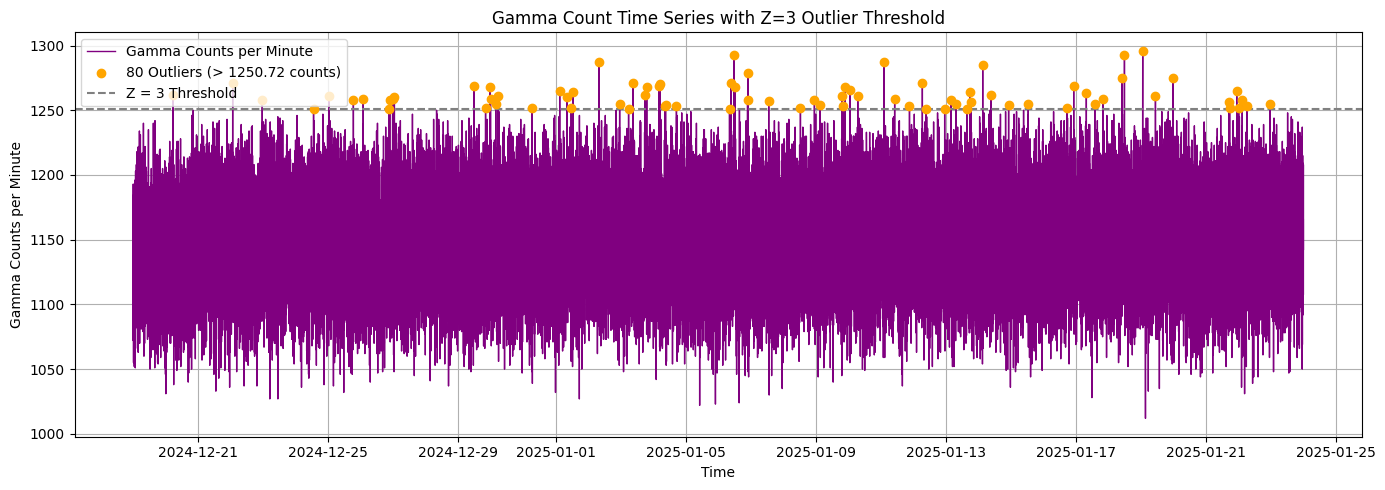

In [ ]:
plot_gamma_outliers(Z=3)